# Assignment 
***

#### **1. Importing relevant packages** 
_Remember to install pydst (used to fetch data fro Statistics Denmark) if you have not already done that. Use: pip install git+https://github.com/elben10/pydst_

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pydst
from pandas_datareader import wb
import ipywidgets as  widgets

#### **2. Importing data from online source**
We extract data from DST and start by getting an overview of the available data. 

In [2]:
# a. extrating data
Dst = pydst.Dst(lang='en')

# b. getting list of top-level subjects
Dst.get_subjects()

,active,desc,hasSubjects,id
0,True,Population and elections,True,02
1,True,Living conditions,True,05
2,True,Education and knowledge,True,03
3,True,Culture and National Church,True,18
4,True,"Labour, income and wealth",True,04
5,True,Prices and consumption,True,06
6,True,National accounts and government finances,True,14
7,True,Money and credit market,True,16
8,True,External economy,True,13
9,True,Business sector in general,True,07


We choose the category **Living conditions** 

In [3]:
Dst.get_tables(subjects=['05']).head()

,active,firstPeriod,id,latestPeriod,text,unit,updated,variables
0,True,2008Q1,FOLK1A,2019Q1,Population at the first day of the quarter,number,2019-02-11 08:00:00,"[region, sex, age, marital status, time]"
1,True,2008Q1,FOLK1B,2019Q1,Population at the first day of the quarter,number,2019-02-11 08:00:00,"[region, sex, age, citizenship, time]"
2,True,2008Q1,FOLK1C,2019Q1,Population at the first day of the quarter,number,2019-02-11 08:00:00,"[region, sex, age, ancestry, country of origin..."
3,True,2008Q1,FOLK1D,2019Q1,Population at the first day of the quarter,number,2019-02-11 08:00:00,"[region, sex, age, citizenship, time]"
4,True,2008Q1,FOLK1E,2019Q1,Population at the first day of the quarter,number,2019-02-11 08:00:00,"[region, sex, age, ancestry, time]"


Within the category **Living conditions** we choose **straf22** which contains data on reported criminal offences by _region_ and _type_ on a yearly basis from 2007 to 2018. 

In [4]:
Dst.get_data(table_id = 'straf22')

,OMRÅDE,OVERTRÆD,ANMSIGT,TID,INDHOLD
0,All Denmark,"Nature of the offence, total",Reported criminal offences,2007,514317


From this dataset, we construct a dataframe containing all observations on the variables _Area_, _Type of offence_, _Reported/charged_ and _Time_

In [5]:
crime_api = Dst.get_data(table_id = 'straf22',
                         variables={'OMRÅDE':['*'], 
                                    'OVERTRÆD':['*'],
                                    'ANMSIGT':['*'],
                                    'TID':['*']})


and we rename the variable names from danish to english

In [6]:
crime_api.rename(columns = {'OMRÅDE':'AREA', 'OVERTRÆD':'TYPE','ANMSIGT':'REP/CHAR',
                            'TID':'TIME', 'INDHOLD':'CONTENT'}, inplace=True)

In [7]:
crime_api.head(10)

,AREA,TYPE,REP/CHAR,TIME,CONTENT
0,Allerød,Assault causing actual bodily harm,Reported criminal offences,2010,5
1,Allerød,Assault causing actual bodily harm,Charge,2007,3
2,Allerød,Assault causing actual bodily harm,Charge,2008,6
3,Allerød,Assault causing actual bodily harm,Charge,2009,10
4,Allerød,Assault causing actual bodily harm,Charge,2010,4
5,Allerød,Involuntary manslaughter/bodily harm,Reported criminal offences,2009,1
6,Allerød,Involuntary manslaughter/bodily harm,Charge,2009,1
7,Allerød,Offences against life and limb,Reported criminal offences,2008,1
8,Allerød,Offences against life and limb,Reported criminal offences,2009,2
9,Allerød,Offences against life and limb,Reported criminal offences,2010,1


#### **3. Overall impression of reported criminal offences on the country level (2007-2018)**
Selecting data and creating "table"


In [8]:
# Selecting country level, criminal offences total, reported criminal offences and
# all time periods
crime_land = crime_api.loc[(crime_api['AREA'] == 'All Denmark') & 
              (crime_api['TYPE'] == 'Nature of the offence, total') & 
              (crime_api['REP/CHAR'] == 'Reported criminal offences'),:]

# Sorting data from 2007 to 2018
crime_land_sort = crime_land.sort_values(by='TIME',ascending=True)

# Showing the timeseries in table
crime_land_sort.head(len(crime_land_sort['TIME'])).style.hide_index()

AREA,TYPE,REP/CHAR,TIME,CONTENT
All Denmark,"Nature of the offence, total",Reported criminal offences,2007,514317
All Denmark,"Nature of the offence, total",Reported criminal offences,2008,548169
All Denmark,"Nature of the offence, total",Reported criminal offences,2009,562406
All Denmark,"Nature of the offence, total",Reported criminal offences,2010,545767
All Denmark,"Nature of the offence, total",Reported criminal offences,2011,558061
All Denmark,"Nature of the offence, total",Reported criminal offences,2012,531967
All Denmark,"Nature of the offence, total",Reported criminal offences,2013,535859
All Denmark,"Nature of the offence, total",Reported criminal offences,2014,518963
All Denmark,"Nature of the offence, total",Reported criminal offences,2015,501881
All Denmark,"Nature of the offence, total",Reported criminal offences,2016,516576


Zooming in at the the development in reported criminal offences since 2007-2018 on the country level

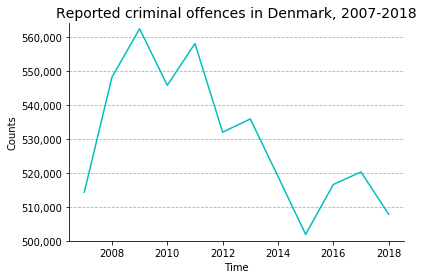

In [9]:
# a. actual plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
x = crime_land_sort['TIME']
y = crime_land_sort['CONTENT']

# b. labels
ax.set_xlabel('Time')
ax.set_ylabel('Counts')
ax.set_title('Reported criminal offences in Denmark, 2007-2018', fontsize=14)   

# c. including a grid, thousands separator on y-axis, removing plot frame lines
# and setting range of y-axis.
plt.grid(b=None, linestyle='--',which='major', axis='y')
ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
ax.spines["top"].set_visible(False)       
ax.spines["right"].set_visible(False) 
plt.ylim(500000, 564000) 

# d. plotting cyan colored
ax.plot(x,y, 'c' )

#### **4. Investigating heterogeneity across Danish regions**
First step is to select observations on the regional level. 

In [10]:
# a. Constructing a boolean taking the value True if the AREA category contains the word
# Region and then selecting all these observations.
M = crime_api.AREA.str.contains('Region')
crime_M = crime_api[M]

# b. Selecting reported criminal offences in total from 2007-2018 
crime_reg = crime_M.loc[(crime_api['TYPE'] == 'Nature of the offence, total') & 
              (crime_api['REP/CHAR'] == 'Reported criminal offences'),:]

# c. sorting in chronological order
crime_reg_sort = crime_reg.sort_values(by='TIME',ascending=True)

crime_reg_sort.head(12)

,AREA,TYPE,REP/CHAR,TIME,CONTENT
961,Region Hovedstaden,"Nature of the offence, total",Reported criminal offences,2007,192915
1810,Region Syddanmark,"Nature of the offence, total",Reported criminal offences,2007,104273
3094,Region Sjælland,"Nature of the offence, total",Reported criminal offences,2007,64419
11322,Region Midtjylland,"Nature of the offence, total",Reported criminal offences,2007,101943
12175,Region Nordjylland,"Nature of the offence, total",Reported criminal offences,2007,44020
962,Region Hovedstaden,"Nature of the offence, total",Reported criminal offences,2008,201759
1811,Region Syddanmark,"Nature of the offence, total",Reported criminal offences,2008,113217
3095,Region Sjælland,"Nature of the offence, total",Reported criminal offences,2008,75670
12176,Region Nordjylland,"Nature of the offence, total",Reported criminal offences,2008,46149
11323,Region Midtjylland,"Nature of the offence, total",Reported criminal offences,2008,105901


#### **5. Summary statistics on sub-criminal offences**

In this section, we want to look at sub-criminal offences at the municipality level in 2018. Thus, we remove regions and observations on the country level. Furthermore, the variable REP/CHAR contains both reported and charged offences, hence, we split this variable into two separate variables in order to easily calculate the ratio between them later on. 

In [11]:
# a. deleting rows containing the words 'Region' and 'All Denmark'
for val in ['Region', 'All Denmark']: 
    I = crime_api.AREA.str.contains(val)
    crime_api = crime_api.loc[I == False] # keep everything else

Split the data into two dataframes in order to get separable variables for "reported" and "charged".
<br> **1. First** split: reported offences

In [12]:
# a. selection criteria
K = crime_api.TYPE.str.contains(', total')

# b. creating dataset with only reported offences
crime_mun = crime_api[K].copy()
crime_mun_rep = crime_mun.loc[(crime_mun['TIME'] == 2018) & 
              (crime_api['REP/CHAR'] == 'Reported criminal offences'),:]
crime_mun_rep.rename(columns = {'CONTENT':'REPORTED'}, inplace=True)
del crime_mun_rep['REP/CHAR']

# c. evaluating the result
crime_mun_rep.head().style.hide_index()


/Users/Christoffer/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


AREA,TYPE,TIME,REPORTED
Slagelse,"Crimes of violence, total",2018,564
Slagelse,"Offences against property, total",2018,3939
Syddjurs,"Other offences, total",2018,46
Syddjurs,"Special acts, total",2018,618
Syddjurs,"Nature of the offence, total",2018,2203


**2. Second** split: charged offences

In [13]:
# a. using same selection criteria to create dataset with charges only
crime_mun = crime_api[K]
crime_mun_char = crime_mun.loc[(crime_mun['TIME'] == 2018) & 
              (crime_api['REP/CHAR'] == 'Charge'),:].copy()
crime_mun_char.rename(columns = {'CONTENT':'CHARGED'}, inplace=True)
del crime_mun_char['REP/CHAR']

# b. evaluating the result
crime_mun_char.head().style.hide_index()


AREA,TYPE,TIME,CHARGED
Slagelse,"Crimes of violence, total",2018,380
Slagelse,"Offences against property, total",2018,823
Syddjurs,"Other offences, total",2018,35
Syddjurs,"Special acts, total",2018,285
Syddjurs,"Nature of the offence, total",2018,644


Printing number of rows in new variables

In [14]:
print(f'Observations in crime_mun_char = {len(crime_mun_char)}')
print(f'Observations in crime_mun_rep  = {len(crime_mun_rep)}')

Observations in crime_mun_char = 690
Observations in crime_mun_rep  = 694


The difference between the two measures indicates that there are four areas where there are reported offences, however, no charges. This could reflect the fact that reported and charged offences of the same crime are not necessarily registered in the same year.

**3. Merge** two separate datasets back together into one dataframe.

In [15]:
# a. merging
crime_mun_merged = pd.merge(crime_mun_rep, crime_mun_char, 
                            on=['AREA', 'TYPE', 'TIME'], how='outer')
# b. replace NaNs with zeroes
crime_mun_merged['CHARGED'] = crime_mun_merged['CHARGED'].fillna(0)

# c. for some reason, 'CHARGED' turned into floats. Change them back to integers
crime_mun_merged['CHARGED'] = crime_mun_merged['CHARGED'].astype(int)
crime_mun_merged.head(10).style.hide_index()

AREA,TYPE,TIME,REPORTED,CHARGED
Slagelse,"Crimes of violence, total",2018,564,380
Slagelse,"Offences against property, total",2018,3939,823
Syddjurs,"Other offences, total",2018,46,35
Syddjurs,"Special acts, total",2018,618,285
Syddjurs,"Nature of the offence, total",2018,2203,644
Norddjurs,"Penal Code, total",2018,1534,510
Norddjurs,"Sexual offenses, total",2018,36,27
Norddjurs,"Crimes of violence, total",2018,255,201
Norddjurs,"Offences against property, total",2018,1196,244
Norddjurs,"Other offences, total",2018,47,38


**4. Creating** a new variable called 'ANDEL SIGTEDE', which is the share of reported crimes that actually ends with a criminal charge. The following analysis hinges on one important assumption: 1. There is no guarantee that reported and charged offences of the same crime are registered in the same year. Hence, the ratio of charges relative to reported offences does not necessarily capture the real ratio between charges and reported offences. However, we will assume that reported and charged offences of the same crime are attributed to the same year. 

In [16]:
# a. calculating the ratio
crime_mun_merged['SHARE CHARGED'] = crime_mun_merged['CHARGED'] / crime_mun_merged['REPORTED'] * 100

# b. rounding the number to two decimals
crime_mun_merged['SHARE CHARGED'] = round(crime_mun_merged['SHARE CHARGED'], 2)

# c. showing a sample of 10 observations
crime_mun_merged.sample(10).style.hide_index()

AREA,TYPE,TIME,REPORTED,CHARGED,SHARE CHARGED
Haderslev,"Nature of the offence, total",2018,3439,1287,37.42
Langeland,"Offences against property, total",2018,382,48,12.57
Ballerup,"Other offences, total",2018,169,138,81.66
Ringkøbing-Skjern,"Crimes of violence, total",2018,119,81,68.07
Brønderslev,"Nature of the offence, total",2018,1798,639,35.54
Skanderborg,"Other offences, total",2018,37,23,62.16
Aarhus,"Penal Code, total",2018,25259,5596,22.15
Tårnby,"Penal Code, total",2018,3956,1238,31.29
Brøndby,"Sexual offenses, total",2018,28,16,57.14
Næstved,"Special acts, total",2018,2285,1821,79.69


**Extreme 1:** The 12 municipalities with the highest share of charged offences relative to reported offences in 2018. 

In [17]:
# a. sort in descending order
crime_mun_merged = crime_mun_merged.sort_values(by='SHARE CHARGED',ascending=False)

# b. table of 12 municipalities with highest ratio
crime_mun_merged.head(12).style.hide_index()


AREA,TYPE,TIME,REPORTED,CHARGED,SHARE CHARGED
Samsø,"Other offences, total",2018,1,1,100
Ishøj,"Sexual offenses, total",2018,270,262,97.04
Viborg,"Other offences, total",2018,371,354,95.42
Faxe,"Other offences, total",2018,19,18,94.74
Hjørring,"Sexual offenses, total",2018,182,167,91.76
Odder,"Other offences, total",2018,11,10,90.91
Hørsholm,"Sexual offenses, total",2018,31,28,90.32
Fredensborg,"Sexual offenses, total",2018,72,65,90.28
Syddjurs,"Sexual offenses, total",2018,53,47,88.68
Ikast-Brande,"Sexual offenses, total",2018,26,23,88.46


**Extreme 2:** The 12 municipalities with the lowest share of charged offences relative to reported offences in 2018. 

In [18]:
# a. sort in ascending order
crime_mun_merged = crime_mun_merged.sort_values(by='SHARE CHARGED',ascending=True)

# b. table of 12 municipalities
crime_mun_merged.head(12).style.hide_index()

AREA,TYPE,TIME,REPORTED,CHARGED,SHARE CHARGED
Christiansø,"Nature of the offence, total",2018,1,0,0
Samsø,"Sexual offenses, total",2018,2,0,0
Christiansø,"Special acts, total",2018,1,0,0
Læsø,"Crimes of violence, total",2018,1,0,0
Ikast-Brande,"Special acts, total",2018,14477,412,2.85
Ikast-Brande,"Nature of the offence, total",2018,16093,839,5.21
Gentofte,"Offences against property, total",2018,4827,326,6.75
Egedal,"Offences against property, total",2018,1344,93,6.92
Hørsholm,"Special acts, total",2018,1054,77,7.31
Vallensbæk,"Offences against property, total",2018,655,53,8.09


Calculating the mean of the share of charged offences relative to reported offences by type of offence

In [19]:
crime_mun_merged.groupby('TYPE').mean().sort_values(by='SHARE CHARGED',ascending=False)

,TIME,REPORTED,CHARGED,SHARE CHARGED
TYPE,,,,
"Sexual offenses, total",2018.0,74.040816,51.642857,67.028163
"Other offences, total",2018.0,104.040404,71.383838,66.182525
"Crimes of violence, total",2018.0,281.373737,170.444444,61.941111
"Special acts, total",2018.0,1442.820000,706.280000,52.378800
"Nature of the offence, total",2018.0,5078.240000,1581.580000,31.441100
"Penal Code, total",2018.0,3672.141414,884.141414,24.633737
"Offences against property, total",2018.0,3213.434343,591.191919,17.905354


#### **5. Mapping the ratio of charges to reported offences on the municipality level in a socalled choropleth** 
In the following section we construct a map of Danish municipalities with the share of charges to reported criminal offences indicated by color. To run the map can be cumbersome, since you need to read a shape file, which requires the installation of GDAL and other packages. If you have windows, the road to installation is long and tiredsome. However, se readme-file for links.

In [20]:
# selecting the data to plot in the chloropeth 
crime_mun = crime_mun_merged.copy()
crime_mun1 = crime_mun.loc[(crime_mun['TYPE'] == 'Nature of the offence, total'),:]

crime_mun1.head()

,AREA,TYPE,TIME,REPORTED,CHARGED,SHARE CHARGED
232,Christiansø,"Nature of the offence, total",2018,1,0,0.00
308,Ikast-Brande,"Nature of the offence, total",2018,16093,839,5.21
669,Ærø,"Nature of the offence, total",2018,457,61,13.35
133,Gentofte,"Nature of the offence, total",2018,5884,837,14.23
294,Rudersdal,"Nature of the offence, total",2018,3708,572,15.43


Install **geopandas** (if windows follow links in readme) if not already installed

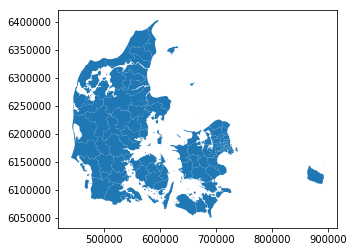

In [21]:
# a. import geopandas
import geopandas as gpd

# b. read shape file
file = 'KOMMUNE.shp'
map_df = gpd.read_file(file)

# c. plot map
map_df.plot()

**Merge** dataset with ratio onto geographical data 

In [22]:
# a. merge through municipality
merged = map_df.set_index('KOMNAVN').join(crime_mun1.set_index('AREA'))

# b. look at data
merged.head()

,FEAT_ID,FEAT_KODE,FEAT_TYPE,FEAT_STTXT,GEOM_STTXT,DAGI_ID,AREAL,REGIONKODE,REGIONNAVN,GYLDIG_FRA,...,TIMEOF_CRE,TIMEOF_PUB,TIMEOF_REV,TIMEOF_EXP,geometry,TYPE,TIME,REPORTED,CHARGED,SHARE CHARGED
Aabenraa,250591,6310,Kommune,vedtaget,endelig,389169,94061.2,1083,Region Syddanmark,2018-01-22,...,2018-01-22,2018-01-22,None,2019-03-23,"POLYGON Z ((532245.9400000001 6079144.94 -999,...","Nature of the offence, total",2018.0,5285.0,2016.0,38.15
Aabenraa,250589,6310,Kommune,vedtaget,endelig,389169,94061.2,1083,Region Syddanmark,2018-01-22,...,2018-01-22,2018-01-22,None,2019-03-23,"POLYGON Z ((532579.09 6078987.87 -999, 532579....","Nature of the offence, total",2018.0,5285.0,2016.0,38.15
Aabenraa,250593,6310,Kommune,vedtaget,endelig,389169,94061.2,1083,Region Syddanmark,2018-01-22,...,2018-01-22,2018-01-22,None,2019-03-23,"POLYGON Z ((529349.23 6107743.85 -999, 529353....","Nature of the offence, total",2018.0,5285.0,2016.0,38.15
Aabenraa,250587,6310,Kommune,vedtaget,endelig,389169,94061.2,1083,Region Syddanmark,2018-01-22,...,2018-01-22,2018-01-22,None,2019-03-23,"POLYGON Z ((536464.0600000001 6107571.33 -999,...","Nature of the offence, total",2018.0,5285.0,2016.0,38.15
Aabenraa,250585,6310,Kommune,vedtaget,endelig,389169,94061.2,1083,Region Syddanmark,2018-01-22,...,2018-01-22,2018-01-22,None,2019-03-23,"POLYGON Z ((529191.3 6107597.05 -999, 529192.6...","Nature of the offence, total",2018.0,5285.0,2016.0,38.15


Create the map

/Users/Christoffer/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:512: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


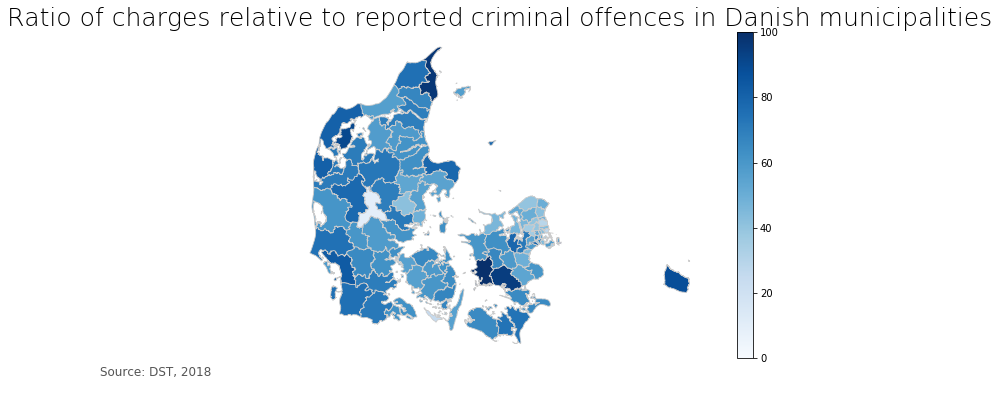

In [23]:
# specify the variable (column in merged dataframe) to visualize on the map
variable = 'SHARE CHARGED'

# range of variable
vmin, vmax = 0, 100

# create figure and axes 
fig, ax = plt.subplots(1,figsize=(10,6))

# plot the map
merged.plot(column=variable,cmap='Blues',linewidth=0.8,ax=ax,edgecolor='0.8')

##### Costumising the map #####
# remove the axis
ax.axis('off')

# Title
ax.set_title('Ratio of charges relative to reported criminal offences in Danish municipalities', fontdict={'fontsize': '25', 'fontweight' : '3'})

# Annotation for the data source
ax.annotate('Source: DST, 2018',xy=(0.1, .08),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')
            
# Colorbar as a legend
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# empty array for the data range
sm._A = []

# The colorbar to the figure
cbar = fig.colorbar(sm)